## Generation of the eCDFs and manual annotations figures

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [34]:
# Naming system
# x[method][12|21][c?]
#   ^       ^      ^-> if c appears it was trained with cosine, mse otherwise
#   |       +--------> 12 if the registration is done from mod. A to B, 21 if B to A
#   +----------------> method name

df = pd.read_csv("results/CurveAlign.csv").sort_values(by="Filename")
xe = df.Error

# ~~~ MSE PART ~~~
# Alpha-AMD (Not multistart)
df = pd.read_csv("results/AlphaAMD.csv").sort_values(by="Index")
xa12 = df[df.IsRegisteredAtoB == 1].Error
xa21 = df[df.IsRegisteredAtoB == 0].Error
# Alpha-AMD (Multistart)
df = pd.read_csv("results/AlphaAMD_MS.csv").sort_values(by="Index")
xm12 = df[df.IsRegisteredAtoB == 1].Error
xm21 = df[df.IsRegisteredAtoB == 0].Error
# SIFT
xs12 = pd.read_csv("results/SIFT_AtoB.csv").sort_values(by="Filename").Error
xs21 = pd.read_csv("results/SIFT_BtoA.csv").sort_values(by="Filename").Error
# Mutual Information (Original)
xmio12 = pd.read_csv("results/MI_original_BFT_SHGR.csv").sort_values(by="Filename").Error
xmio21 = pd.read_csv("results/MI_original_SHGT_BFR.csv").sort_values(by="Filename").Error
# Mutual Infoormation (Latent spaces)
xmil12 = pd.read_csv("results/MI_CoMIR_AtoB.csv").sort_values(by="Filename").Error
xmil21 = pd.read_csv("results/MI_CoMIR_BtoA.csv").sort_values(by="Filename").Error

# ~~~ COSINE PART ~~~
# Alpha-AMD (Not multistart)
df = pd.read_csv("results/cosine_AlphaAMD.csv").sort_values(by="Index")
xa12c = df[df.IsRegisteredAtoB == 1].Error
xa21c = df[df.IsRegisteredAtoB == 0].Error
# Alpha-AMD (Multistart)
df = pd.read_csv("results/cosine_AlphaAMD_MS.csv").sort_values(by="Index")
xm12c = df[df.IsRegisteredAtoB == 1].Error
xm21c = df[df.IsRegisteredAtoB == 0].Error
# SIFT
xs12c = pd.read_csv("results/cosine_SIFT_AtoB.csv").sort_values(by="Filename").Error
xs21c = pd.read_csv("results/cosine_SIFT_BtoA.csv").sort_values(by="Filename").Error
# Mutual Infoormation (Latent spaces)
xmil12c = pd.read_csv("results/cosine_MI_CoMIR_AtoB.csv", sep=",").sort_values(by="Filename").Error
xmil21c = pd.read_csv("results/cosine_MI_CoMIR_BtoA.csv", sep=",").sort_values(by="Filename").Error

In [29]:
xh = np.array([
    pd.read_csv(f"results/Manual_{i}.csv").Error.dropna() for i in range(6)
])

In [30]:
from collections import namedtuple
import warnings

WilcoxonResult = namedtuple('WilcoxonResult', ('statistic', 'pvalue'))
def wilcoxon(x, y=None, zero_method="wilcox", correction=False,
             alternative="two-sided"):
    if zero_method not in ["wilcox", "pratt", "zsplit"]:
        raise ValueError("Zero method should be either 'wilcox' "
                         "or 'pratt' or 'zsplit'")

    if alternative not in ["two-sided", "less", "greater"]:
        raise ValueError("Alternative must be either 'two-sided', "
                         "'greater' or 'less'")

    if y is None:
        d = np.asarray(x)
        if d.ndim > 1:
            raise ValueError('Sample x must be one-dimensional.')
    else:
        x, y = map(np.asarray, (x, y))
        if x.ndim > 1 or y.ndim > 1:
            raise ValueError('Samples x and y must be one-dimensional.')
        if len(x) != len(y):
            raise ValueError('The samples x and y must have the same length.')
        d = x - y

    if zero_method in ["wilcox", "pratt"]:
        n_zero = np.sum(d == 0, axis=0)
        if n_zero == len(d):
            raise ValueError("zero_method 'wilcox' and 'pratt' do not work if "
                             "the x - y is zero for all elements.")

    if zero_method == "wilcox":
        # Keep all non-zero differences
        d = np.compress(np.not_equal(d, 0), d, axis=-1)

    count = len(d)
    if count < 10:
        warnings.warn("Sample size too small for normal approximation.")

    r = st.rankdata(abs(d))
    r_plus = np.sum((d > 0) * r, axis=0)
    r_minus = np.sum((d < 0) * r, axis=0)
    W = r_plus - r_minus

    if zero_method == "zsplit":
        r_zero = np.sum((d == 0) * r, axis=0)
        r_plus += r_zero / 2.
        r_minus += r_zero / 2.

    # return min for two-sided test, but r_plus for one-sided test
    # the literature is not consistent here
    # r_plus is more informative since r_plus + r_minus = count*(count+1)/2,
    # i.e. the sum of the ranks, so r_minus and the min can be inferred
    # (If alternative='pratt', r_plus + r_minus = count*(count+1)/2 - r_zero.)
    # [3] uses the r_plus for the one-sided test, keep min for two-sided test
    # to keep backwards compatibility
    if alternative == "two-sided":
        T = min(r_plus, r_minus)
    else:
        T = r_plus
    mn = count * (count + 1.) * 0.25
    se = count * (count + 1.) * (2. * count + 1.)

    if zero_method == "pratt":
        r = r[d != 0]
        # normal approximation needs to be adjusted, see Cureton (1967)
        mn -= n_zero * (n_zero + 1.) * 0.25
        se -= n_zero * (n_zero + 1.) * (2. * n_zero + 1.)

    replist, repnum = st.find_repeats(r)
    if repnum.size != 0:
        # Correction for repeated elements.
        se -= 0.5 * (repnum * (repnum * repnum - 1)).sum()

    se = np.sqrt(se / 24)

    # apply continuity correction if applicable
    d = 0
    if correction:
        if alternative == "two-sided":
            d = 0.5 * np.sign(T - mn)
        elif alternative == "less":
            d = -0.5
        else:
            d = 0.5

    # compute statistic and p-value using normal approximation
    z = (T - mn - d) / se
    if alternative == "two-sided":
        prob = 2. * st.distributions.norm.sf(abs(z))
    elif alternative == "greater":
        # large T = r_plus indicates x is greater than y; i.e.
        # accept alternative in that case and return small p-value (sf)
        prob = st.distributions.norm.sf(z)
    else:
        prob = st.distributions.norm.cdf(z)
    direction = 2 * (r_plus < r_minus) - 1
    return W, prob, direction

p-value: 0.5472000344575845
p-value: 4.9809900969124296e-11


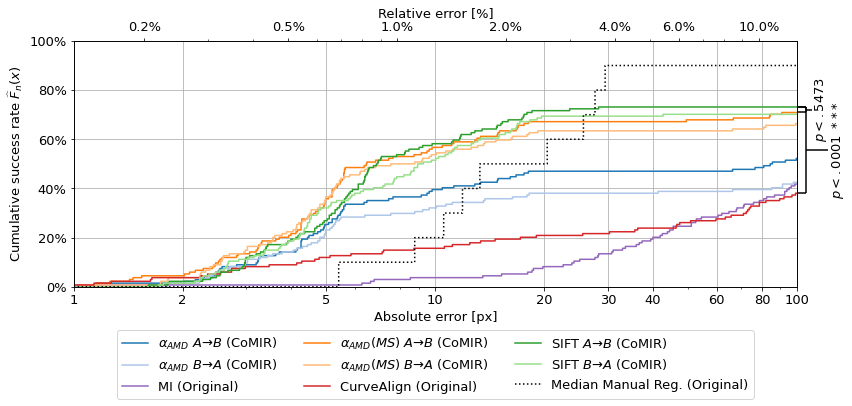

In [33]:
import scipy.stats as st
import scipy.special as sp
import matplotlib.ticker as mtick
import matplotlib as mpl
from cycler import cycler
plt.rcParams.update({'font.size': 13})

def plot_cdf(x, bins, cumulative=True, bands=True, confidence=0.95, **kwargs):
    hist, bin_edges = np.histogram(x, bins=bins)
    N = len(x)
    # We need to pad because plt.step(where="mid") has half steps
    # in the beginning and in the end. (purely graphical purpose)
    hist = np.pad(np.cumsum(hist), 1, mode="edge")
    p = hist / N
    # plotting
    t = np.concatenate([
        bins[0:1],
        (bins[:-1] + bins[1:]) / 2,
        bins[-1:]
    ])
    plt.step(t, p, where="mid", **kwargs)

    # Confidence bands
    # Binomial (Clopper-Pearson)
    alpha = 1. - confidence
    z = 1 - alpha/2.
    errl = st.beta.ppf(alpha/2, hist, N-hist+1)
    errh = st.beta.ppf(1-alpha/2, hist+1, N-hist)
    errl[hist == 0], errh[hist == 0] = 0, 1 - (alpha/2)**(1/N)
    errl[hist == N], errh[hist == N] = (alpha/2)**(1/N), 1

    opacity = 0.15 if bands else 0.0
    plt.fill_between(t,
        errl, errh,
        interpolate=False, step="mid", alpha=opacity
    )
    return hist / N

def pvalue_ubound(pvalue, d=4):
    return np.ceil(pvalue * 10**d) / 10**d

def pstar(p, latex=False):
    b = [0, 1e-3, 1e-2, 5e-2, 1e-1, 1e0]
    s = ["***", "**", "*", "+", ""]
    idx = np.digitize(p, b).item() - 1
    if latex:
        return "\\!".join(s[idx])
    return s[idx]

def annotate_pvalue(xpos, p1, p2, x1, x2, margin=16, margin2=4, stars=True):
    yl, yh = p1[-1], p2[-1]
    ym = (yh + yl)/2
    # Plotting the bracket
    plt.hlines([yl, yh], xpos, xpos+margin, zorder=3, clip_on=False)
    plt.vlines(xpos+margin, yl, yh, zorder=3, clip_on=False)
    plt.hlines(ym, xpos+margin, xpos+margin+margin2, zorder=3, clip_on=False)
    statistic, pvalue, direction = wilcoxon(
        np.clip(x1, 0, xpos),
        np.clip(x2, 0, xpos)
    )
    print("p-value:", pvalue)
    # Plotting the p-value
    pvalue= pvalue_ubound(pvalue, 4)
    ptext = "$p<" + f"{pvalue:.4f}".lstrip("0")
    if stars:
        ptext += f"~{pstar(pvalue, latex=True)}$"
    else:
        ptext += "$"
    plt.text(xpos+margin+margin2+1, ym, ptext, zorder=3, rotation="vertical", va="center")

plt.figure(figsize=(12, 6))
mpl.rcParams['axes.prop_cycle'] = cycler(color=plt.cm.tab20.colors)
plt.grid()

# EMPIRICAL CUMULATIVE DISTRIBUTION FUNCTIONS
bins = np.logspace(0., 2., 1000)
p1 = plot_cdf(xa12, bins, bands=False, confidence=0.95, color="C0", label="$\\alpha_{AMD} ~ A \\to B$ (CoMIR)")
p2 = plot_cdf(xa21, bins, bands=False, confidence=0.95, color="C1", label="$\\alpha_{AMD} ~ B \\to A$ (CoMIR)")
p3 = plot_cdf(xmio12, bins, bands=False, confidence=0.95, color="C8", label="MI (Original)")
p4 = plot_cdf(xm12, bins, bands=False, confidence=0.95, color="C2", label="$\\alpha_{AMD} (MS) ~ A \\to B$ (CoMIR)")
p5 = plot_cdf(xm21, bins, bands=False, confidence=0.95, color="C3", label="$\\alpha_{AMD} (MS) ~ B \\to A$ (CoMIR)")
p6 = plot_cdf(xe, bins, bands=False, confidence=0.95, color="C6", label="CurveAlign (Original)")
p7 = plot_cdf(xs12, bins, bands=False, confidence=0.95, color="C4", label="SIFT $A \\to B$ (CoMIR)")
p8 = plot_cdf(xs21, bins, bands=False, confidence=0.95, color="C5", label="SIFT $B \\to A$ (CoMIR)")
p9 = plot_cdf(np.median(xh, axis=0), bins, bands=False, confidence=0.95, color="black", ls=":", label="Median Manual Reg. (Original)")

# WILCOXON PAIRED TEST (P-VALUES)
xpos = bins[-1]
m = 6
annotate_pvalue(xpos, p4, p7, xm21.to_numpy(), xs12.to_numpy(), margin=m)
annotate_pvalue(xpos, p7, p6, xs12.to_numpy(), xe.to_numpy(), margin=m, margin2=m+10)

#plt.legend(bbox_to_anchor=(0, -0.4, 1, 0.2), loc=8, ncol=3)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3)
ax = plt.gca()
# Main axis
# y axis
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
ax.set_ylabel("Cumulative success rate $\widehat{F}_n(x)$")
# x axis
ax.set_xscale("log")
ax.xaxis.set_major_formatter(mtick.ScalarFormatter())
ax.set_xlabel("Absolute error [px]")
xticks = np.array([1, 2, 5, 10, 20, 30, 40, 60, 80, 100])
ax.set_xticks(xticks)
ax.set_xlim(bins[0], bins[-1])
ax.set_ylim(0, 1)

#''' Secondary axis (x axis)
imwidth = 784
ax2 = ax.twiny()
ax2.set_xlabel("Relative error [%]")
ax2.set_xscale("log")
ax2.xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=1))
xticks = np.array([0.2, 0.5, 1, 2, 4, 6, 10]) / 100
ax2.set_xticks(xticks)
ax2.set_xlim(bins[0]/imwidth, bins[-1]/imwidth)
#'''

#plt.title("Empirical CDF")
plt.tight_layout()
plt.savefig("base_methods_cdf_wide.pdf", bbox_inches='tight', pad_inches=0.10)

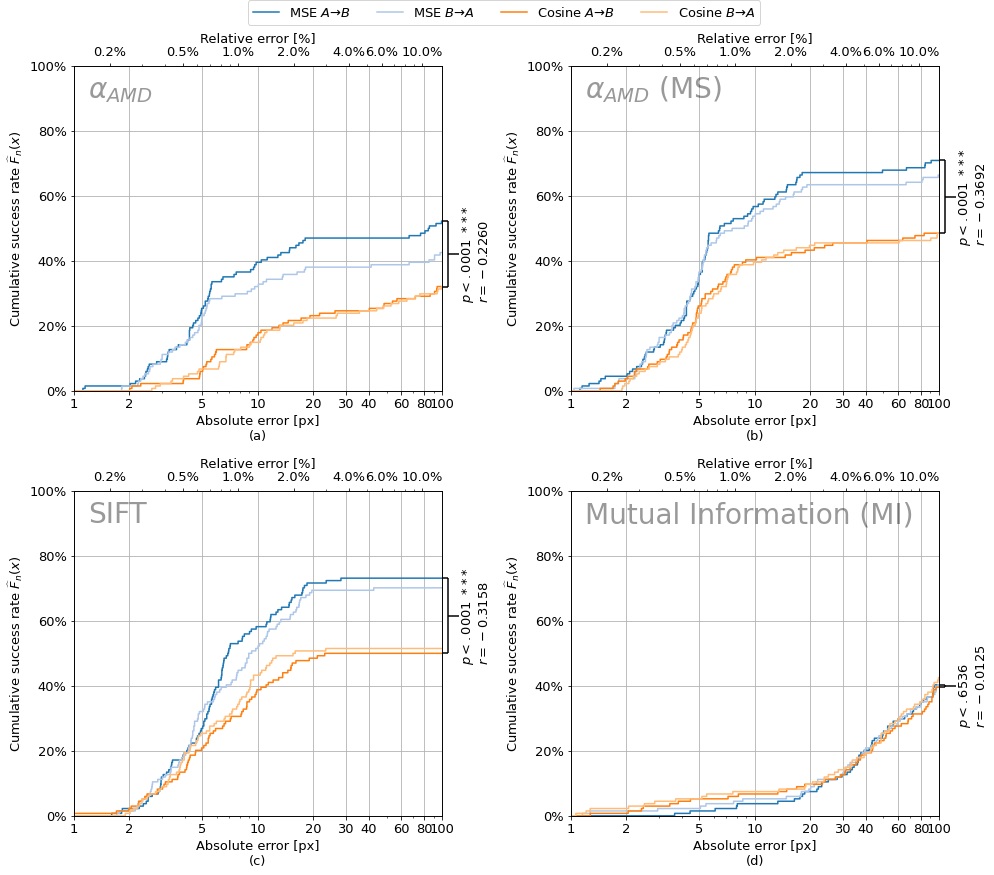

In [36]:
import scipy.stats as st
import scipy.special as sp
import matplotlib.ticker as mtick
import matplotlib as mpl
from cycler import cycler
plt.rcParams.update({'font.size': 13})

def plot_cdf(ax, x, bins, cumulative=True, bands=True, confidence=0.95, **kwargs):
    hist, bin_edges = np.histogram(x, bins=bins)
    N = len(x)
    # We need to pad because plt.step(where="mid") has half steps
    # in the beginning and in the end. (purely graphical purpose)
    hist = np.pad(np.cumsum(hist), 1, mode="edge")
    p = hist / N
    # plotting
    t = np.concatenate([
        bins[0:1],
        (bins[:-1] + bins[1:]) / 2,
        bins[-1:]
    ])
    ax.step(t, p, where="mid", **kwargs)
    return hist / N
    # Confidence bands
    # Binomial (Clopper-Pearson)
    alpha = 1. - confidence
    z = 1 - alpha/2.
    errl = st.beta.ppf(alpha/2, hist, N-hist+1)
    errh = st.beta.ppf(1-alpha/2, hist+1, N-hist)
    errl[hist == 0], errh[hist == 0] = 0, 1 - (alpha/2)**(1/N)
    errl[hist == N], errh[hist == N] = (alpha/2)**(1/N), 1

    opacity = 0.15 if bands else 0.0
    fig.fill_between(t,
        errl, errh,
        interpolate=False, step="mid", alpha=opacity
    )
    return hist / N

def pvalue_ubound(pvalue, d=4):
    return np.ceil(pvalue * 10**d) / 10**d

def pstar(p, latex=False):
    b = [0, 1e-3, 1e-2, 5e-2, 1e-1, 1e0]
    s = ["***", "**", "*", "+", ""]
    idx = np.digitize(p, b).item() - 1
    if latex:
        return "\\!".join(s[idx])
    return s[idx]

def annotate_pvalue(ax, xpos, p1, p2, x1, x2, margin=16, margin2=4, stars=True):
    yl, yh = p1[-1], p2[-1]
    ym = (yh + yl)/2
    # Plotting the bracket
    ax.hlines([yl, yh], xpos, xpos+margin, zorder=3, clip_on=False)
    ax.vlines(xpos+margin, yl, yh, zorder=3, clip_on=False)
    ax.hlines(ym, xpos+margin, xpos+margin+margin2, zorder=3, clip_on=False)
    W, pvalue, direction = wilcoxon(
        np.clip(x1, 0, xpos),
        np.clip(x2, 0, xpos)
    )
    # Plotting the direction of the rejection
    #ptext = "$>$" if -direction > 0 else "$<$"
    #ax.text(xpos+margin/2, ym, ptext, zorder=3, rotation="vertical", ha="center", va="center")
    # Plotting the p-value
    pvalue= pvalue_ubound(pvalue, 4)
    ptext = "$p<" + f"{pvalue:.4f}".lstrip("0")
    if stars:
        ptext += f"~{pstar(pvalue, latex=True)}$"
    else:
        ptext += "$"
    S = len(x1) * (len(x1) + 1) / 2
    ptext += f"\n$r={W/S:.4f}$"
    ax.text(xpos+margin+margin2+1, ym, ptext, zorder=3, rotation="vertical", va="center")

fig, ax = plt.subplots(2, 2, figsize=(14, 12))
ax = ax.ravel()
mpl.rcParams['axes.prop_cycle'] = cycler(color=plt.cm.tab20.colors)

# EMPIRICAL CUMULATIVE DISTRIBUTION FUNCTIONS
bins = np.logspace(0., 2., 1000)
p1  = plot_cdf(ax[0], xa12, bins, bands=False, confidence=0.95)
p2  = plot_cdf(ax[0], xa21, bins, bands=False, confidence=0.95)
p3  = plot_cdf(ax[0], xa12c, bins, bands=False, confidence=0.95)
p4  = plot_cdf(ax[0], xa21c, bins, bands=False, confidence=0.95)
p5  = plot_cdf(ax[1], xm12, bins, bands=False, confidence=0.95)
p6  = plot_cdf(ax[1], xm21, bins, bands=False, confidence=0.95)
p7  = plot_cdf(ax[1], xm12c, bins, bands=False, confidence=0.95)
p8  = plot_cdf(ax[1], xm21c, bins, bands=False, confidence=0.95)
p9  = plot_cdf(ax[2], xs12, bins, bands=False, confidence=0.95)
p10 = plot_cdf(ax[2], xs21, bins, bands=False, confidence=0.95)
p11 = plot_cdf(ax[2], xs12c, bins, bands=False, confidence=0.95)
p12 = plot_cdf(ax[2], xs21c, bins, bands=False, confidence=0.95)
p13 = plot_cdf(ax[3], xmil12, bins, bands=False, confidence=0.95, label="MSE $A \\to B$")
p14 = plot_cdf(ax[3], xmil21, bins, bands=False, confidence=0.95, label="MSE $B \\to A$")
p15 = plot_cdf(ax[3], xmil12c, bins, bands=False, confidence=0.95, label="Cosine $A \\to B$")
p16 = plot_cdf(ax[3], xmil21c, bins, bands=False, confidence=0.95, label="Cosine $B \\to A$")

# WILCOXON PAIRED TEST (P-VALUES)
xpos = bins[-1]
m = 8
annotate_pvalue(ax[0], xpos,  p1,  p3, xa12.to_numpy(), xa12c.to_numpy(), margin=m, margin2=2*m)
annotate_pvalue(ax[1], xpos,  p5,  p7, xm12.to_numpy(), xm12c.to_numpy(), margin=m, margin2=2*m)
annotate_pvalue(ax[2], xpos,  p9, p11, xs12.to_numpy(), xs12c.to_numpy(), margin=m, margin2=2*m)
annotate_pvalue(ax[3], xpos, p13, p15, xmil12.to_numpy(), xmil12c.to_numpy(), margin=m, margin2=2*m)

methods = ["$\\alpha_{AMD}$", "$\\alpha_{AMD}$ (MS)", "SIFT", "Mutual Information (MI)"]
letters = ["a", "b", "c", "d"]
for i, axe in enumerate(ax):
    axe.grid()
    # Main axis
    axe.annotate(methods[i], (1.2, .90), fontsize=28, alpha=0.4, zorder=3)
    # y axis
    axe.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
    axe.set_ylabel("Cumulative success rate $\widehat{F}_n(x)$")
    # x axis
    axe.set_xscale("log")
    axe.xaxis.set_major_formatter(mtick.ScalarFormatter())
    axe.set_xlabel(f"Absolute error [px]\n({letters[i]})")
    xticks = np.array([1, 2, 5, 10, 20, 30, 40, 60, 80, 100])
    axe.set_xticks(xticks)
    axe.set_xlim(bins[0], bins[-1])
    axe.set_ylim(0, 1)

    #''' Secondary axis (x axis)
    imwidth = 784
    ax2 = axe.twiny()
    ax2.set_xlabel("Relative error [%]")
    ax2.set_xscale("log")
    ax2.xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=1))
    xticks = np.array([0.2, 0.5, 1, 2, 4, 6, 10]) / 100
    ax2.set_xticks(xticks)
    ax2.set_xlim(bins[0]/imwidth, bins[-1]/imwidth)
    #'''

handles, labels = ax[-1].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.5, 1.02), loc='upper center', ncol=4)

#plt.title("Empirical CDF")
plt.tight_layout()
plt.savefig("base_methods_cdf_mse_vs_cosine.pdf", bbox_inches='tight', pad_inches=0.15)

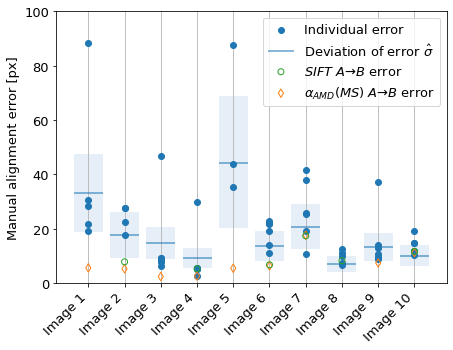

In [8]:
idx = pd.read_csv(f"results/Manual_0.csv").Error.dropna(axis=0).index
N = len(idx)

def G(n):
    # Gamma correction of the Rayleigh parameter estimator
    return np.exp(sp.loggamma(n) - sp.loggamma(n + 0.5) + .5 * np.log(n))

sigmas = []
for i in range(N):
    mask = xh[:, i] < 100
    sigmas.append(G(mask.sum()) * np.sqrt(0.5*np.mean(xh[mask, i]**2, axis=0)))
sigmas = np.array(sigmas)

plt.figure(figsize=(7, 5))
t = np.arange(10)+1
plt.xticks(t)
for i in range(6):
    plt.scatter(t, xh[i], c="C0", zorder=3)
for i in range(10):
    p = xm12.iloc[idx].to_numpy()
    if p[i] < 100:
        plt.scatter(t[i], p[i], marker="d", zorder=4, facecolors='none', edgecolors='C2')
for i in range(10):
    p = xs12.iloc[idx].to_numpy()
    if p[i] < 100:
        plt.scatter(t[i], p[i], marker="o", zorder=4, facecolors='none', edgecolors='C4')
plt.hlines(sigmas, t-.4, t+.4, color="C0", label="Deviation of error $\hat \sigma$", alpha=0.7)
Ks = np.sum(xh < 100, axis=0)
lo, hi = np.array(st.chi.interval(.95, df=2*Ks))
lo *= sigmas / np.sqrt(2*Ks)
hi *= sigmas / np.sqrt(2*Ks)
plt.bar(t, bottom=lo, height=hi-lo, color="C1", alpha=0.3, label="95% C.I. of $\hat \sigma$")

plt.scatter([], [], c="C0", label="Individual error")
plt.scatter([], [], marker="d", label="$\\alpha_{AMD} (MS) ~ A \\to B$ error", facecolors='none', edgecolors='C2')
plt.scatter([], [], marker="o", label="$SIFT ~ A \\to B$ error", facecolors='none', edgecolors='C4')

plt.grid(axis="x")
#plt.gca().set_xticklabels(imglabels, rotation=45)
plt.gca().set_xticklabels([f"Image {i+1}" for i in range(N)], rotation=45, ha="right")
#plt.xlabel("Images")
plt.ylabel("Manual alignment error [px]")
plt.ylim(0, 100)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(np.array(handles)[[1, 0, 3, 2]], np.array(labels)[[1, 0, 3, 2]])
plt.savefig("manual_annotations.pdf", bbox_inches='tight', pad_inches=0.10)